In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip uninstall opencv-python
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python

In [276]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import time

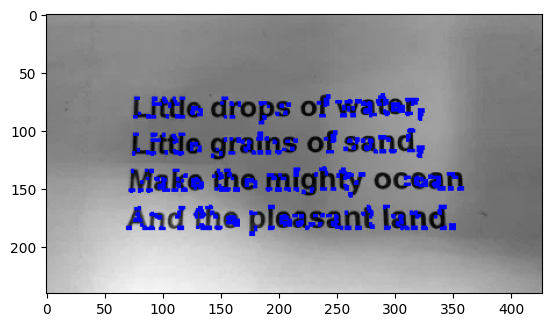

(<matplotlib.image.AxesImage at 0x157c5bfd0>, None)

In [277]:
filename = 'data/01.tif'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray, 2, 3, 0.04)
#result is dilated for marking the corners, not important
dst = cv.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
img_dots = img
img_dots[dst > 0.1 * dst.max()] = [0, 0, 255]
cv.imwrite('dst.jpg', img_dots)
plt.imshow(img_dots),plt.show()

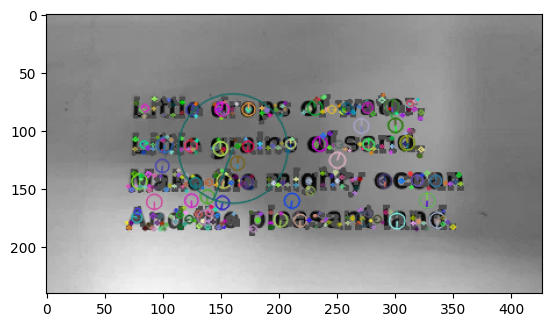

(<matplotlib.image.AxesImage at 0x157cbcc10>, None)

In [278]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create(contrastThreshold=0.07)
kp, des = sift.detectAndCompute(gray, None)
img_sift = cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv.imwrite('sift_keypoints.jpg',img)
plt.imshow(img_sift),plt.show()

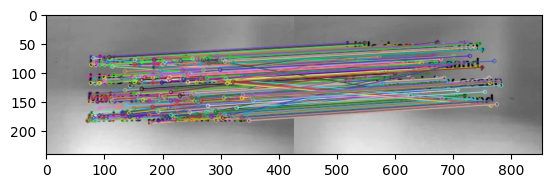

(<matplotlib.image.AxesImage at 0x157d69910>, None)

In [281]:
img1 = cv.imread('data/01.tif',cv.IMREAD_GRAYSCALE)         # queryImage
img2 = cv.imread('data/12.tif',cv.IMREAD_GRAYSCALE)         # trainImage

#  Initiate SIFT detector
sift = cv.SIFT_create(contrastThreshold=0.05)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# BFMatcher with default params
# bf = cv.BFMatcher()
# matches = bf.knnMatch(des1, des2, k=2)

flann = cv.FlannBasedMatcher()
matches = flann.knnMatch(des1, des2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append([m])

# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()

In [286]:
def find_all_matches(kp_arr, descr_arr, matcher = cv.FlannBasedMatcher()):
    assert len(kp_arr) == len(descr_arr)

    img_num = len(kp_arr)
    matched_points = dict()
    all_points = dict()

    for src_num in range(img_num):
        for dst_num in range(src_num):
            src_idx, dst_idx = get_matches(matcher, descr_arr[src_num], descr_arr[dst_num])
            src_p_arr = [kp_arr[src_num][idx] for idx in src_idx]
            dst_p_arr = [kp_arr[dst_num][idx] for idx in dst_idx]
            assert len(src_p_arr) == len(dst_p_arr)

            match_num = len(src_p_arr)
            for cur_idx in range(match_num):
                src_p = src_p_arr[cur_idx]
                dst_p = dst_p_arr[cur_idx]

                if src_p in all_points:
                    src_resp = all_points[src_p]
                    if dst_p in all_points:
                        dst_resp = all_points[dst_p]
                        src_neighbours = matched_points[src_resp]
                        if (src_resp != dst_resp):
                            for dst_neighbour in matched_points[dst_resp]:
                                all_points[dst_neighbour] = src_resp
                                src_neighbours.append(dst_neighbour)
                    else:
                        all_points[dst_p] = src_resp
                        matched_points[src_resp].append(dst_p)
                else:
                    if dst_p in all_points:
                        dst_resp = all_points[dst_p]
                        all_points[src_p] = dst_resp
                        matched_points[dst_resp].append(src_p)
                    else:
                        all_points[src_p] = all_points[dst_p] = src_p
                        matched_points[src_p] = [src_p, dst_p]
                
    lens_list = [len(matched_list) for matched_list in matched_points.values()]
    matches = [lens_list.count(num) for num in range(1, img_num + 1)]
    for i in range(img_num - 2, -1, -1):
        matches[i] += matches[i + 1]
    return matches
            

In [287]:
IMG_NUM = 12

In [288]:
def get_points(detector):
    kp_arr = []
    des_arr = []
    all_time = 0
    all_points = 0
    for i in range(1, IMG_NUM + 1):
        num = str(i)
        if i < 10:
            num = "0" + num

        img = cv.imread(f'data/{num}.tif', cv.IMREAD_GRAYSCALE)

        start = time.time()
        kp, des = sift.detectAndCompute(img, None)
        end = time.time()
        all_time += end - start

        kp_arr.append(kp)
        des_arr.append(des)
        all_points += len(kp)
    return kp_arr, des_arr, all_time / all_points

In [289]:
def apply_method(method):
    kp_arr, des_arr, time = get_points(method)
    matches = find_all_matches(kp_arr, des_arr)
    matches[0] = len(kp_arr[0])
    matches = np.array(matches, dtype=float)
    matches /= matches[0]
    return matches, time

In [290]:
SIFT, SIFT_time = apply_method(cv.SIFT_create())
BRISK, BRISK_time = apply_method(cv.BRISK_create())
ORB, ORB_time = apply_method(cv.ORB_create())

In [291]:
print("SIFT time:", SIFT_time)
print("BRISK time:", BRISK_time)
print("ORB time:", ORB_time)

SIFT time: 1.70705138011204e-05
BRISK time: 1.6208921753195433e-05
ORB time: 1.6217897942496987e-05


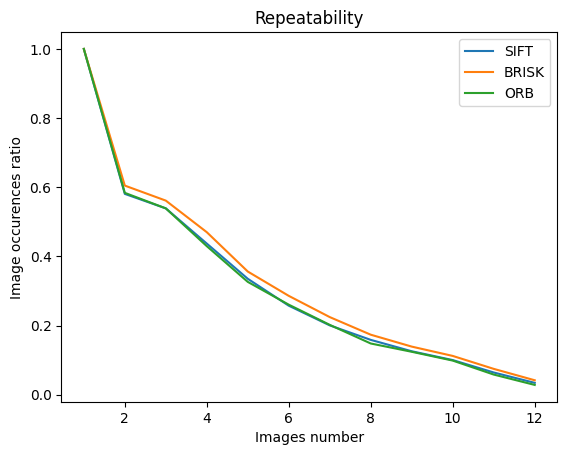

In [292]:
x = list(range(1, IMG_NUM + 1))
plt.plot(x, SIFT, label="SIFT")
plt.plot(x, BRISK, label="BRISK")
plt.plot(x, ORB,  label="ORB")
  
plt.xlabel('Images number')
plt.ylabel('Image occurences ratio')
plt.title('Repeatability')
plt.legend()
plt.show()